## <font color = red> Press double arrow above to restart kernel and re-run notebook </font>

# Daily Florida Current and Mean Daily Virginia Key Tide, 2021

## Martina Rogers and Mike Sukop, Florida International University

### For on-line implementation see https://github.com/alan-turing-institute/the-turing-way/blob/master/workshops/boost-research-reproducibility-binder/workshop-presentations/zero-to-binder-python.md#running-code-is-more-complicated-than-displaying-code

###  Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, show, legend, ylabel
import json
import urllib.request
from urllib.request import urlopen
from pprint import pprint
import pandas as pd
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
import matplotlib.dates as dl
import datetime
from datetime import date, timedelta

### Download Florida Current data

In [2]:
url='https://www.aoml.noaa.gov/phod/floridacurrent/FC_cable_transport_2021.dat'
current=np.loadtxt(url,skiprows=22,usecols=(0,1,2,3))
d1 = pd.DataFrame(current,columns=['year','month','day','transport']) # converts from 4 columns to pandas data frame
d3 = {'year':'year','month':'month','day':'day'}
d1['date'] = pd.to_datetime(d1.rename(columns=d3)[list(d3.values())]) # creates date from year, month and day
print(d1.columns)
print(d1.tail())

Index(['year', 'month', 'day', 'transport', 'date'], dtype='object')
       year  month   day  transport       date
268  2021.0    9.0  26.0       32.5 2021-09-26
269  2021.0    9.0  27.0       32.2 2021-09-27
270  2021.0    9.0  28.0       32.0 2021-09-28
271  2021.0    9.0  29.0       31.0 2021-09-29
272  2021.0    9.0  30.0       31.0 2021-09-30


### Download Viginia Key predicted and observed tide

#### Estimate daily average from hourly data

In [3]:
websource = urllib.request.urlopen('https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions'+\
                                   '&application=NOS.COOPS.TAC.WL&begin_date=20210101&end_date=20211231&datum=NAVD'+\
                                   '&station=8723214&time_zone=lst_ldt&units=english&interval=h&format=json')
predictions = json.loads(websource.read().decode())
#pprint(predictions)
dates_pred = [i['t'] for i in predictions["predictions"]] # extracts only time 't'
dates_pred=np.array(dates_pred, dtype='datetime64')
values_pred = [i['v'] for i in predictions['predictions']] #extracts only value 'v'
pred = {'date':dates_pred,'prediction':values_pred}
pred_df = pd.DataFrame(pred)
pred_df['year'] = pd.DatetimeIndex(pred_df['date']).year
pred_df['month'] = pd.DatetimeIndex(pred_df['date']).month
pred_df['day'] = pd.DatetimeIndex(pred_df['date']).dayofyear
pred_df['prediction'] = pd.to_numeric(pred_df['prediction'], errors ='coerce')
g_day = pred_df.groupby(['year', 'month','day'])
daily_mean_pred = g_day.aggregate({'prediction':np.mean})
daily_mean_pred = daily_mean_pred.reset_index()
#print (daily_mean_pred.reset_index())

websource1 = urllib.request.urlopen('https://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20210101' + \
                                    '&end_date=20211231&station=8723214&product=hourly_height&datum=NAVD&units=english' + \
                                    '&time_zone=lst_ldt&interval=h&application=NOS.COOPS.TAC.WL&format=json')
observations = json.loads(websource1.read().decode())
dates_obs = [i['t'] for i in observations["data"]]
dates_obs = np.array(dates_obs, dtype='datetime64')
values_obs = [i['v'] for i in observations['data']]
obs = {'date':dates_obs,'observed':values_obs}
obs_df = pd.DataFrame(obs)
obs_df['year'] = pd.DatetimeIndex(obs_df['date']).year
obs_df['month'] = pd.DatetimeIndex(obs_df['date']).month
obs_df['day'] = pd.DatetimeIndex(obs_df['date']).dayofyear
obs_df['observed'] = pd.to_numeric(obs_df['observed'], errors ='coerce')
 
g_day1 = obs_df.groupby(['year', 'month','day'])
daily_mean_obs = g_day1.aggregate({'observed':np.mean})
daily_mean_obs = daily_mean_obs.reset_index()
print(json.dumps(dict(websource1.headers)))
print(daily_mean_pred.tail())
print(daily_mean_obs)

{"Date": "Fri, 08 Oct 2021 14:48:25 GMT", "Content-Type": "application/json;charset=ISO-8859-1", "Content-Length": "365837", "Connection": "close", "x-amzn-RequestId": "6667194a-b85b-4692-8494-312fff839346", "Access-Control-Allow-Origin": "*", "Access-Control-Allow-Headers": "X-Requested-With", "x-amzn-Remapped-Connection": "keep-alive", "x-amz-apigw-id": "G5MI9HLIIAMFYCA=", "Cache-Control": "no-cache,no-store,must-revalidate", "x-amzn-Remapped-Server": "nginx/1.20.0", "Expires": "Thu, 01 Jan 1970 00:00:00 GMT", "Pragma": "no-cache", "x-amzn-Remapped-Date": "Fri, 08 Oct 2021 14:48:25 GMT"}
     year  month  day  prediction
360  2021     12  361   -1.006417
361  2021     12  362   -0.992750
362  2021     12  363   -0.978625
363  2021     12  364   -0.972625
364  2021     12  365   -0.983292
     year  month  day  observed
0    2021      1    1 -0.998333
1    2021      1    2 -1.175333
2    2021      1    3 -1.289208
3    2021      1    4 -1.240958
4    2021      1    5 -1.099458
..    .

### Preliminary observed data

In [4]:
today = date.today() - timedelta(1)
end_date = str(today.strftime("%Y%m%d"))
start = date.today() - timedelta(30)
start_date = str(start.strftime("%Y%m%d"))
print("Start date:", start_date)
print("End date:", end_date)
url= ('https://tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={}'+\
      '&end_date={}&station=8723214&datum=NAVD&product=water_level&units=english'+
      '&time_zone=lst&interval=h&application=NOS.COOPS.TAC.WL&format=json').format(start_date,end_date)
websource2 = urllib.request.urlopen(url)
wl_site = json.loads(websource2.read().decode())
dates_wl = [i['t'] for i in wl_site["data"]]
dates_wl = np.array(dates_wl, dtype='datetime64')
values_wl = [i['v'] for i in wl_site['data']]
wl = {'date':dates_wl,'observed':values_wl}
wl_df = pd.DataFrame(wl)
wl_df['year'] = pd.DatetimeIndex(wl_df['date']).year
wl_df['month'] = pd.DatetimeIndex(wl_df['date']).month
wl_df['day'] = pd.DatetimeIndex(wl_df['date']).dayofyear
wl_df['observed'] = pd.to_numeric(wl_df['observed'], errors ='coerce')
wl_df['water_level'] = wl_df['observed']
g_day2 = wl_df.groupby(['year', 'month','day'])
daily_mean_wl = g_day2.aggregate({'water_level':np.mean})
daily_mean_wl = daily_mean_wl.reset_index()
print(json.dumps(dict(websource2.headers)))
#print(wl_site)
print(daily_mean_wl)

Start date: 20210908
End date: 20211007
{"Date": "Fri, 08 Oct 2021 14:48:26 GMT", "Content-Type": "application/json;charset=ISO-8859-1", "Content-Length": "543047", "Connection": "close", "x-amzn-RequestId": "d2d5e267-b026-454e-9e68-f1e8be3b5a73", "Access-Control-Allow-Origin": "*", "Access-Control-Allow-Headers": "X-Requested-With", "x-amzn-Remapped-Connection": "keep-alive", "x-amz-apigw-id": "G5MJGF6MoAMFl4g=", "Cache-Control": "no-cache,no-store,must-revalidate", "x-amzn-Remapped-Server": "nginx/1.20.0", "Expires": "Thu, 01 Jan 1970 00:00:00 GMT", "Pragma": "no-cache", "x-amzn-Remapped-Date": "Fri, 08 Oct 2021 14:48:26 GMT"}
    year  month  day  water_level
0   2021      9  251    -0.241188
1   2021      9  252    -0.187646
2   2021      9  253    -0.222254
3   2021      9  254    -0.342004
4   2021      9  255    -0.352265
5   2021      9  256    -0.506396
6   2021      9  257    -0.318421
7   2021      9  258    -0.259167
8   2021      9  259    -0.283737
9   2021      9  260   

### Estimate tide residuals

In [5]:
tide1 = daily_mean_pred.merge(daily_mean_obs, how='left', on=['year','month','day'])
tide = tide1.merge(daily_mean_wl, how='left', on=['year','month','day'])
tide['residuals'] = tide['observed'] - tide['prediction']
tide['residuals_prelim'] = tide['water_level'] - tide['prediction']
tide['day'] = pd.to_datetime(tide['day'], format='%j').dt.strftime('%d')
d3 = {'year':'year','month':'month','day':'day'}
tide['date'] = pd.to_datetime(tide.rename(columns=d3)[list(d3.values())])
#tide = tide.dropna(subset=['residuals', 'residuals_prelim'], how='all')
print(tide.columns)
print(tide)

Index(['year', 'month', 'day', 'prediction', 'observed', 'water_level',
       'residuals', 'residuals_prelim', 'date'],
      dtype='object')
     year  month day  prediction  observed  water_level  residuals  \
0    2021      1  01   -1.070500 -0.998333          NaN   0.072167   
1    2021      1  02   -1.089625 -1.175333          NaN  -0.085708   
2    2021      1  03   -1.102458 -1.289208          NaN  -0.186750   
3    2021      1  04   -1.107917 -1.240958          NaN  -0.133042   
4    2021      1  05   -1.104583 -1.099458          NaN   0.005125   
..    ...    ...  ..         ...       ...          ...        ...   
360  2021     12  27   -1.006417       NaN          NaN        NaN   
361  2021     12  28   -0.992750       NaN          NaN        NaN   
362  2021     12  29   -0.978625       NaN          NaN        NaN   
363  2021     12  30   -0.972625       NaN          NaN        NaN   
364  2021     12  31   -0.983292       NaN          NaN        NaN   

     residuals_p

### Moons

In [6]:
Perigee = [pd.to_datetime('2021-01-09'),pd.to_datetime('2021-02-03'),pd.to_datetime('2021-03-02'),pd.to_datetime('2021-03-30'),
           pd.to_datetime('2021-04-27'),pd.to_datetime('2021-05-26'),pd.to_datetime('2021-06-23'),pd.to_datetime('2021-07-21'),
           pd.to_datetime('2021-08-17'),pd.to_datetime('2021-09-11'),pd.to_datetime('2021-10-08'),
           pd.to_datetime('2021-11-05'),pd.to_datetime('2021-12-04'),pd.to_datetime('2022-01-02')]

Apogee = ['2021-01-21','2021-02-18','2021-03-18','2021-04-14','2021-05-11','2021-06-08','2021-07-05','2021-08-02',
          '2021-08-30','2021-09-26','2021-10-24','2021-11-21','2021-12-18','2022-01-17']

### Plot predicted and observed tide at Virginia Key

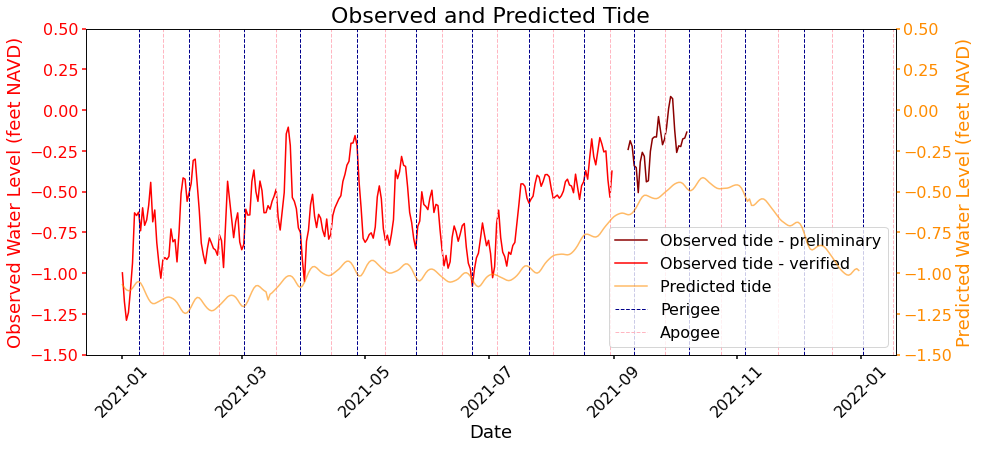

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
fig.subplots_adjust(right=0.75)

ax1 = ax.twinx()
p1, = ax.plot(tide['date'], tide['water_level'], color='darkred', label="Observed tide - preliminary")
p2, = ax.plot(tide['date'], tide['observed'], color='red', label="Observed tide - verified")
p3, = ax1.plot(tide['date'], tide['prediction'], 'darkorange', alpha=0.6, label="Predicted tide")
for xp in Perigee:
    p5 = ax.axvline(x=xp, color='darkblue', linestyle='--', lw=1, label='Perigee')
for xa in Apogee:
    p6 = ax.axvline(x=xa, color='lightpink', linestyle='--', lw=1, label='Apogee')

ax.set_xlabel("Date", fontsize= 18)
ax.set_ylabel("Observed Water Level (feet NAVD)", fontsize= 18)
ax1.set_ylabel("Predicted Water Level (feet NAVD)", fontsize= 18)
ax1.set_title('Observed and Predicted Tide', fontsize=22)
ax.set_ylim([-1.5,0.5])
ax1.set_ylim([-1.5,0.5])
#ax.set_xlim(['2021-01','2022-01'])

ax.yaxis.label.set_color(p2.get_color())
ax1.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p2.get_color(), **tkw,labelsize = 16)
ax1.tick_params(axis='y', colors=p3.get_color(), **tkw,labelsize = 16)
ax.tick_params(axis='x', **tkw, rotation=45,labelsize = 16)

lines = [p1, p2,p3,p5,p6]
ax.legend(lines, [l.get_label() for l in lines], fontsize = 16)

plt.show()

### Plot Tide Residuals

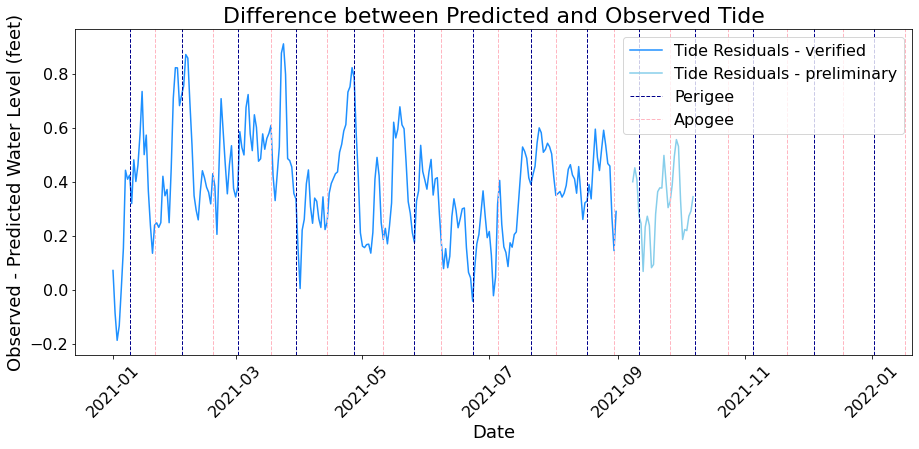

In [8]:
fig = plt.figure(figsize=(15,6))
p1, =plt.plot(tide['date'], tide['residuals'],'-', color='dodgerblue', label='Tide Residuals - verified')
p2, =plt.plot(tide['date'], tide['residuals_prelim'],'-', color='skyblue', label='Tide Residuals - preliminary')
for xp in Perigee:
    p5 =plt.axvline(x=xp, color='darkblue', linestyle='--', lw=1, label='Perigee')
for xa in Apogee:
    p6 =plt.axvline(x=xa, color='lightpink', linestyle='--', lw=1, label='Apogee')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Observed - Predicted Water Level (feet)", fontsize=18)
plt.title("Difference between Predicted and Observed Tide", fontsize=22)
lines = [p1, p2,p5,p6]
plt.legend(lines,[l.get_label() for l in lines],loc='upper right',fontsize=16)

### Plot Florida Current

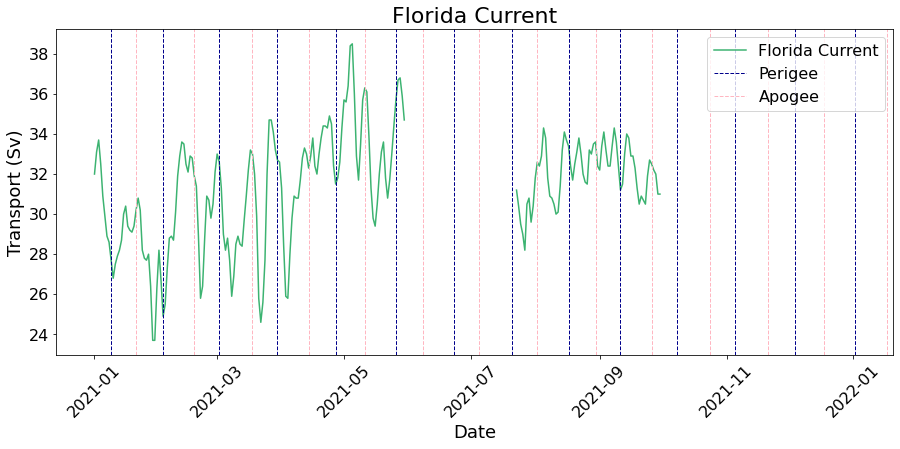

In [9]:
fig = plt.figure(figsize=(15,6))
p1, = plt.plot(d1['date'],d1['transport'],'-', color='mediumseagreen', label = 'Florida Current')
for xp in Perigee:
    p5 =plt.axvline(x=xp, color='darkblue', linestyle='--', lw=1, label='Perigee')
for xa in Apogee:
    p6 =plt.axvline(x=xa, color='lightpink', linestyle='--', lw=1, label='Apogee')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Transport (Sv)", fontsize=18)
plt.title("Florida Current", fontsize=22)
lines = [p1, p5,p6]
plt.legend(lines,[l.get_label() for l in lines],loc='upper right',fontsize=16)

### Plot predicted and observed tide at Virginia Key, and Florida Current

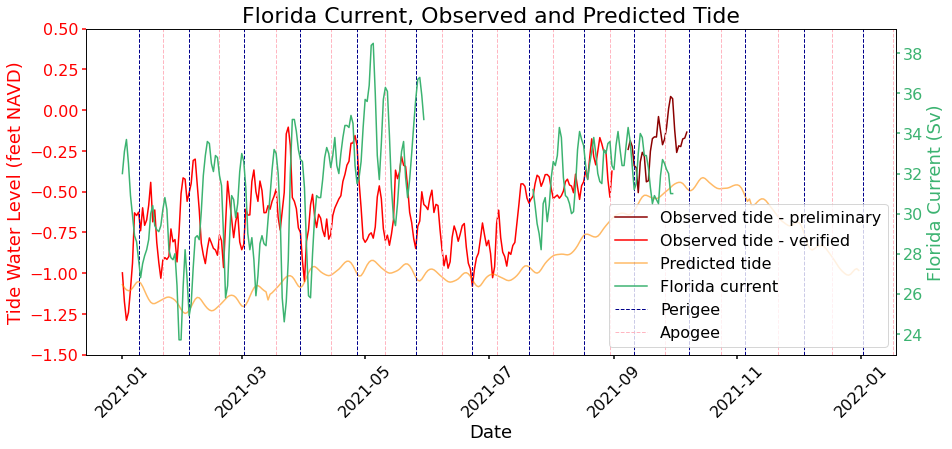

In [10]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
fig.subplots_adjust(right=0.75)

ax1 = ax.twinx()
p1, = ax.plot(tide['date'], tide['water_level'], color='darkred', label="Observed tide - preliminary")
p2, = ax.plot(tide['date'], tide['observed'], color='red', label="Observed tide - verified")
p3, = ax.plot(tide['date'], tide['prediction'], 'darkorange', alpha=0.6, label="Predicted tide")
p4, = ax1.plot(d1['date'],d1['transport'], '-', color='mediumseagreen', label="Florida current")
for xp in Perigee:
    p5 = ax.axvline(x=xp, color='darkblue', linestyle='--', lw=1, label='Perigee')
for xa in Apogee:
    p6 = ax.axvline(x=xa, color='lightpink', linestyle='--', lw=1, label='Apogee')

ax.set_xlabel("Date", fontsize= 18)
ax.set_ylabel("Tide Water Level (feet NAVD)", fontsize= 18)
ax1.set_ylabel("Florida Current (Sv)", fontsize= 18)
ax1.set_title('Florida Current, Observed and Predicted Tide', fontsize=22)
ax.set_ylim([-1.5,0.5])
#ax1.set_ylim([-1.5,0.5])

ax.yaxis.label.set_color(p2.get_color())
ax1.yaxis.label.set_color(p4.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p2.get_color(), **tkw,labelsize = 16)
ax1.tick_params(axis='y', colors=p4.get_color(), **tkw,labelsize = 16)
ax.tick_params(axis='x', **tkw, rotation=45,labelsize = 16)

lines = [p1, p2,p3,p4,p5,p6]
ax.legend(lines, [l.get_label() for l in lines],loc='lower right', fontsize = 16)

plt.show()

### Plot Florida Current and Tide Residuals

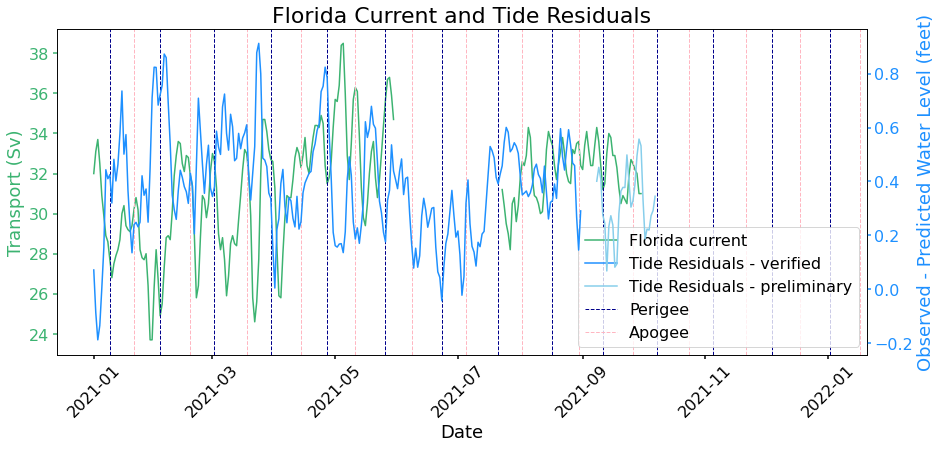

In [11]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
fig.subplots_adjust(right=0.75)

ax1 = ax.twinx()
p1, = ax.plot(d1['date'],d1['transport'], '-', color='mediumseagreen', label="Florida current")
p2, = ax1.plot(tide['date'], tide['residuals'],'-', color='dodgerblue', label="Tide Residuals - verified")
p3, = ax1.plot(tide['date'], tide['residuals_prelim'],'-', color='skyblue', label="Tide Residuals - preliminary")
for xp in Perigee:
    p5 = ax.axvline(x=xp, color='darkblue', linestyle='--', lw=1, label='Perigee')
for xa in Apogee:
    p6 = ax.axvline(x=xa, color='lightpink', linestyle='--', lw=1, label='Apogee')

ax.set_xlabel("Date", fontsize= 18)
ax.set_ylabel("Transport (Sv)", fontsize= 18)
ax1.set_ylabel("Observed - Predicted Water Level (feet)", fontsize= 18)
ax1.set_title('Florida Current and Tide Residuals', fontsize=22)

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw,labelsize = 16)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw,labelsize = 16)
ax.tick_params(axis='x', **tkw, rotation=45,labelsize = 16)

lines = [p1, p2,p3,p5,p6]
ax.legend(lines, [l.get_label() for l in lines], fontsize = 16)

plt.show()